# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Lab 04**: Data Unions & Joins Pipeline

**Date**: September 23rd 2025

**Student Name**: Luis Roberto Chávez Mancilla

**Professor**: Pablo Camarillo Ramirez

## Create SparkSession

In [43]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on SparkSQL") \
    .master("spark://9835fefe4923:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

### Generamos los esquemas

In [44]:
from robertoman.spark_utils import SparkUtils

agencies_schema = SparkUtils.generate_schema([("agency_id", "string"), ("agency_info", "string")])
cars_schema = SparkUtils.generate_schema([("car_id", "int"), ("car_info", "string")])
customers_schema = SparkUtils.generate_schema([("customer_id", "int"), ("customer_info", "string")])
rental_cars_schema = SparkUtils.generate_schema([("rental_id", "int"), ("rental_info", "string")])

### Create DataFrames

In [45]:
from pyspark.sql.functions import get_json_object

base_path = "/opt/spark/work-dir/data/"

agencies_df = (
    spark.read.schema(agencies_schema)
    .option("header", "true")
    .csv(base_path + "car_service/agencies")
)
agencies_df = agencies_df.withColumn(
    "agency_name", get_json_object(agencies_df.agency_info, "$.agency_name")
)


cars_df = (
    spark.read.option("header", "true")
    .schema(cars_schema)
    .csv(base_path + "car_service/cars")
)

brands_df = (
    spark.read.option("header", "true")
    .schema(cars_schema)
    .csv(base_path + "car_service/brands")
)

customers_df = (
    spark.read.option("header", "true")
    .schema(customers_schema)
    .csv(base_path + "car_service/customers")
)

rental_cars_df = (
    spark.read.option("header", "true")
    .schema(rental_cars_schema)
    .csv(base_path + "car_service/rentals")
)

### Extract JSON Info

In [46]:
agencies_df = agencies_df.withColumn(
    "agency_name", get_json_object(agencies_df.agency_info, "$.agency_name")
).drop("agency_info")
cars_df = cars_df.withColumn(
    "car_name", get_json_object(cars_df.car_info, "$.car_name")
).drop("car_info")
customers_df = customers_df.withColumn(
    "customer_name", get_json_object(customers_df.customer_info, "$.customer_name")
).drop("customer_info")

rental_cars_df = (
    rental_cars_df.withColumn(
        "car_id", get_json_object(rental_cars_df.rental_info, "$.car_id")
    )
    .withColumn(
        "customer_id", get_json_object(rental_cars_df.rental_info, "$.customer_id")
    )
    .withColumn("agency_id", get_json_object(rental_cars_df.rental_info, "$.agency_id"))
    .drop("rental_info")
)

### Join Transformations

In [47]:
rental_cars_df = rental_cars_df.join(cars_df, on="car_id", how="left") \
                                .join(customers_df, on="customer_id", how="left") \
                                .join(agencies_df, on="agency_id", how="left") \
                                .drop("agency_id", "customer_id", "car_id")

In [48]:
rental_cars_df.show(6)

+---------+--------------------+---------------+-------------+
|rental_id|            car_name|  customer_name|  agency_name|
+---------+--------------------+---------------+-------------+
|    11891|Wallace-Carlson M...| Margaret Jones|  NYC Rentals|
|    11892|Grimes-Green Model 8|Albert Williams|LA Car Rental|
|    11893|Stewart-Allen Mod...|  Caleb Fleming|      SF Cars|
|    11894|  Campos PLC Model 4|  Andrew Butler|  NYC Rentals|
|    11895|  Wagner LLC Model 1|  Kristin Potts|      SF Cars|
|    11896|Jones, Jefferson ...|   Jeremy Parks|LA Car Rental|
+---------+--------------------+---------------+-------------+
only showing top 6 rows


## Persist Data

In [49]:
!du -sh data/car_service/rentals/

1.1M	data/car_service/rentals/


### CSV Files

In [50]:
rental_cars_df.write.partitionBy("agency_name").mode("overwrite").option(
    "header", True
).csv(base_path + "car_service/output/csv")

In [54]:
!ls data/car_service/output/csv/

'agency_name=LA Car Rental'  'agency_name=SF Cars'	  _SUCCESS
'agency_name=NYC Rentals'    'agency_name=Zapopan Auto'


In [56]:
!du -sh data/car_service/output/csv/

856K	data/car_service/output/csv/


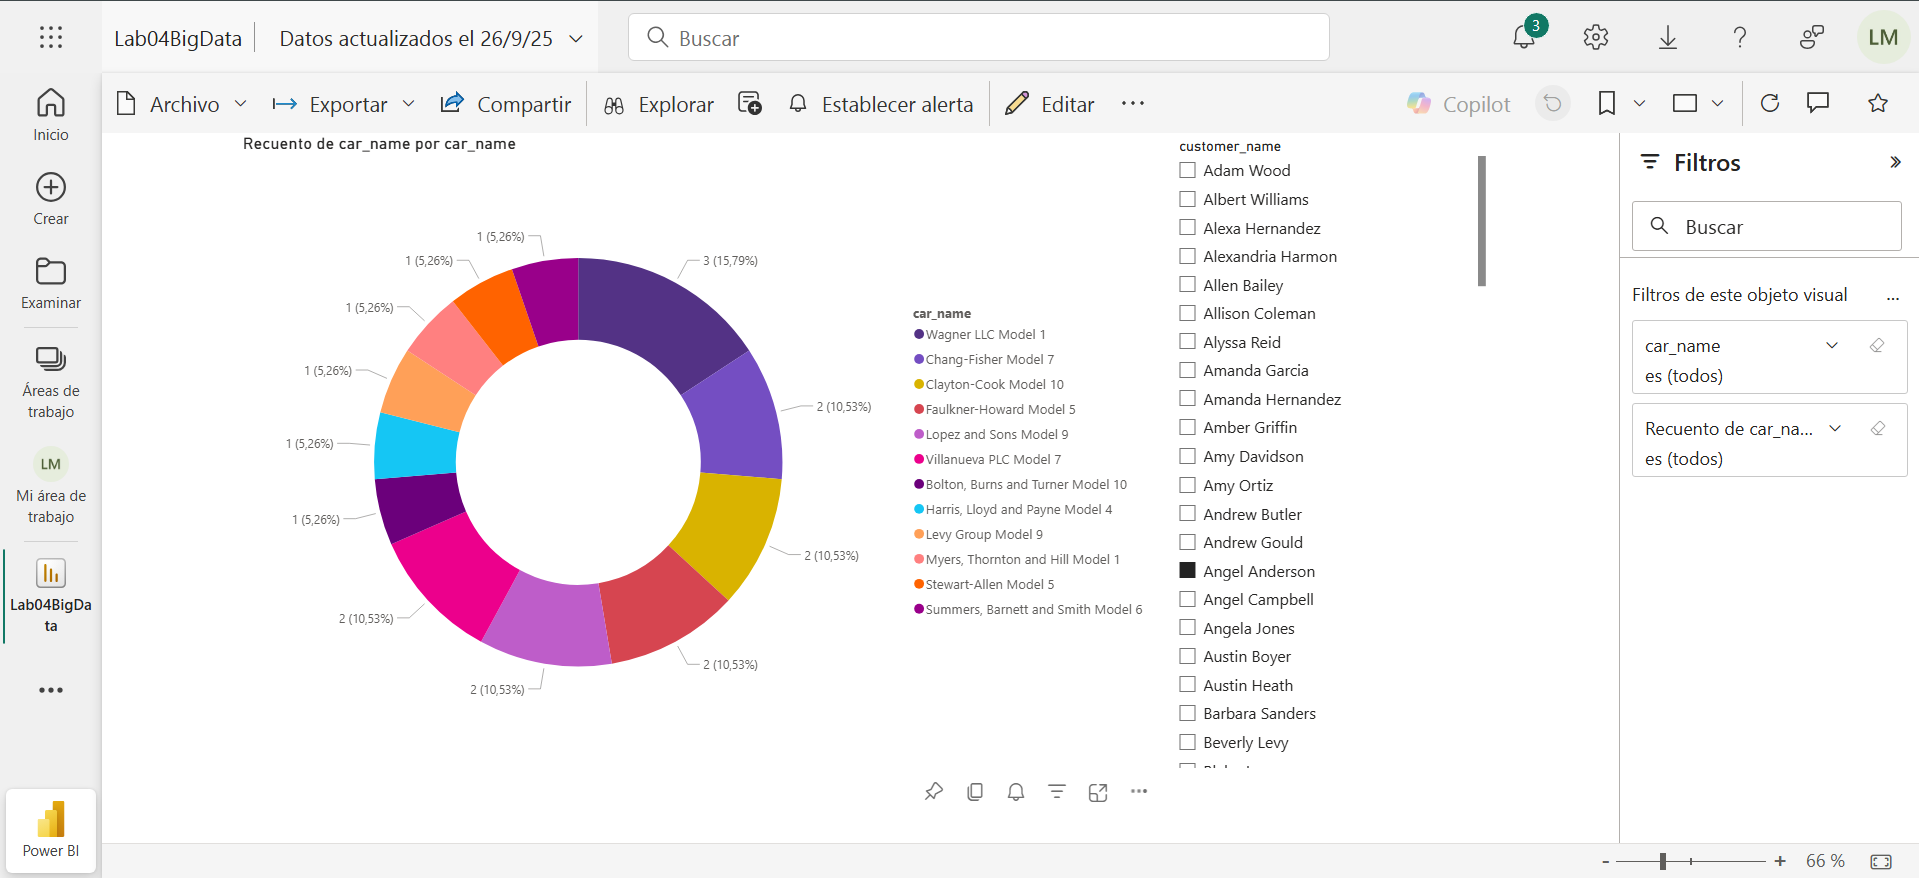

In [53]:
sc.stop()